In [1]:
color_dict = {"c64f16":'tab:orange',
              "c64f64":'tab:orange',
              "c64f128":'tab:orange',
              "vax_c400":'tab:blue',
              "vax_c600":'tab:blue',
              "vax_c800":'tab:blue',
              "vax_c64f16":'tab:green',
              "vax_c64f64":'tab:green',
              "vax_c64f128":'tab:green',
              "nsvf":'tab:red',
              "plenoctrees":'black'}
style_dict = {"c64f16":'dashdot',
              "c64f64":'dashed',
              "c64f128":'solid',
              "vax_c400":'dashdot',
              "vax_c600":'dashed',
              "vax_c800":'solid',
              "vax_c64f16":'dashdot',
              "vax_c64f64":'dashed',
              "vax_c64f128":'solid',
              "nsvf":'solid',
              "plenoctrees":'solid'}
marker_dict = {"c64f16":'x',
               "c64f64":'^',
               "c64f128":'o',
               "vax_c400":'x',
               "vax_c600":'^',
               "vax_c800":'o',
               "vax_c64f16":'x',
               "vax_c64f64":'^',
               "vax_c64f128":'o',
               "nsvf":'o',
               "plenoctrees":'o'}
alpha_dict = {"c64f16":0.4,
               "c64f64":0.5,
               "c64f128":1.,
               "vax_c400":0.4,
               "vax_c600":0.5,
               "vax_c800":1.,
               "vax_c64f16":0.4,
               "vax_c64f64":0.5,
               "vax_c64f128":1.,
               "nsvf":0.5,
               "plenoctrees":0.5}

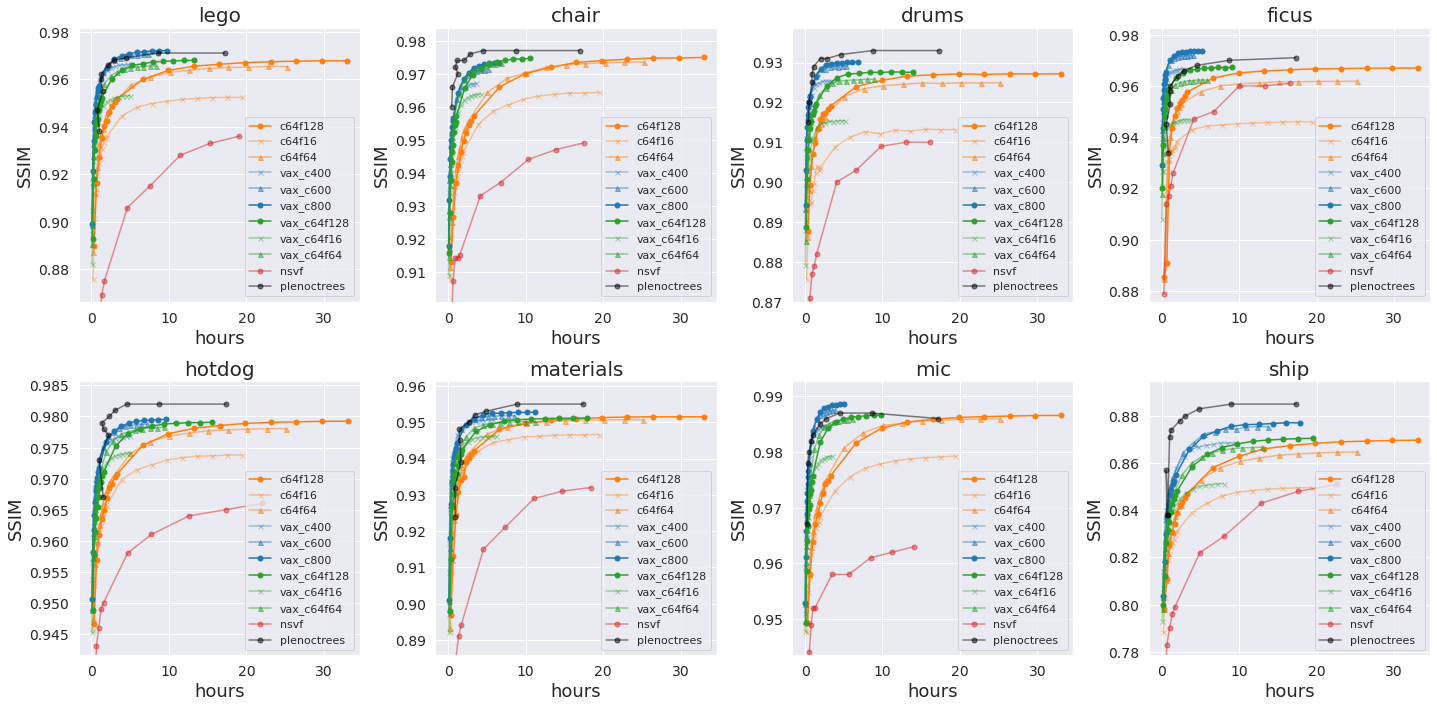

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
sns.set()
sns.color_palette()

xlim = 33
# xlim = 40
val_idx = 3
metrics = 'PSNR' if val_idx == 2 else 'SSIM'

scenes = "lego chair drums ficus hotdog materials mic ship".split()
# scenes = "Bike Lifestyle Palace Robot Spaceship Steamtrain Toad Wineholder".split()

with open("output_vax_nerfdata.pkl", 'rb') as f:
# with open("output_vax_nsvfdata.pkl", 'rb') as f:
    data = pickle.load(f)

with open("output_nsvf_nerfdata.txt", 'r') as f:
# with open("output_nsvf_nsvfdata.txt", 'r') as f:
    data_nsvf = f.readlines()
data_nsvf = [line.strip().replace('\t', ' ') for line in data_nsvf if not line == "\n"]
data_nsvf = [np.array(line.split(), np.float32) if len(line) > 10 else line for line in data_nsvf]
data_nsvf = np.array(data_nsvf, dtype=object).reshape(8,4)
data_nsvf = {datai[0]: [datai[1]/3600., datai[2], datai[3]] for datai in data_nsvf}

with open("output_plen_nerfdata.txt", 'r') as f:
    data_plen = f.readlines()
data_plen = [line.replace('\t', ' ').split() for line in data_plen]
keys = [line[0] for line in data_plen[::8]]
data_plen = [np.array(line, np.float32) for line in data_plen if not line[0] in keys]
data_plen = np.array(data_plen).reshape(8, 7, 10) # 8,7,10
data_plen = dict(zip(keys, data_plen))
data_plen["lego"][2]




fig, axes = plt.subplots(2, 4, figsize=(20,10))

times = dict(zip(color_dict.keys(), [[] for _ in range(len(color_dict))]))

for idx, scene in enumerate(scenes):
    data_scene = [datai for datai in data if scene in datai[0]]
#     data_scene[0], data_scene[1], data_scene[2] = data_scene[0], data_scene[2], data_scene[1]
#     data_scene[3], data_scene[4], data_scene[5] = data_scene[5], data_scene[4], data_scene[3]
    ylims = []
    # NeRF and VaxNeRF
    for datai in data_scene:
        ax = axes[idx//4][idx%4]
        exp_name = datai[0][len(scene)+1:]
        dt = datai[1]
        value = datai[val_idx]
        x = np.array(list(np.arange(1,10) * dt) + list(np.arange(10,101,10) * dt))[:len(value)] / 60.
        times[exp_name].append(x.max())
        linestyle = 'solid' if "vax" in exp_name else 'dashed'
        ylims.append([np.min(value[:np.sum(x < xlim)]), np.max(value[:np.sum(x < xlim)])])
        ax.plot(x,value,label=exp_name,color=color_dict[exp_name],marker=marker_dict[exp_name],alpha=alpha_dict[exp_name],markersize=5)

    # NSVF
    exp_name = "nsvf"
    data_scene_nsvf = data_nsvf[scene]
    meti = 1 if metrics == "PSNR" else 2
    ax.plot(data_scene_nsvf[0],data_scene_nsvf[meti],label=exp_name,color=color_dict[exp_name],marker=marker_dict[exp_name],alpha=alpha_dict[exp_name],markersize=5)

    # PlenOctrees
    exp_name = "plenoctrees"
    data_scene_plen = data_plen[scene]
    meti = 4 if metrics == "PSNR" else 6
    ylims.append([np.min(data_scene_plen[meti]), np.max(data_scene_plen[meti])])
    ax.plot(data_scene_plen[2]/3600.,data_scene_plen[meti],label=exp_name,color=color_dict[exp_name],marker=marker_dict[exp_name],alpha=alpha_dict[exp_name],markersize=5)
    
    ax.set_xlabel('hours', size=18); ax.set_ylabel(metrics, size=18)
    ax.set_xlim([-xlim*0.05, xlim*1.05])
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    ymin, ymax = np.min(np.array(ylims)[:,0]), np.max(np.array(ylims)[:,1])
    margin = (ymax - ymin) * 0.1
    ax.set_ylim([ymin - margin, ymax + margin])
    ax.legend(); ax.set_title(scene, size=20)

plt.tight_layout()
plt.show()

In [3]:
# NeRF
np.max(times["c64f128"]) / np.min(times["vax_c800"]), \
np.max(times["c64f128"]) / np.max(times["vax_c800"]), \
np.max(times["c64f128"]) / np.mean(times["vax_c800"])

(6.611111111111112, 1.8478260869565217, 3.67283950617284)

In [4]:
# NSVF
np.max(times["c64f128"]) / np.min(times["vax_c800"]), \
np.max(times["c64f128"]) / np.max(times["vax_c800"]), \
np.max(times["c64f128"]) / np.mean(times["vax_c800"])

(6.611111111111112, 1.8478260869565217, 3.67283950617284)

In [4]:
np.max(times["c64f128"]) / np.min(times["vax_c64f128"]), \
np.max(times["c64f128"]) / np.max(times["vax_c64f128"]), \
np.max(times["c64f128"]) / np.mean(times["vax_c64f128"])

(3.6615384615384614, 1.6927453769559033, 2.4144052751711893)

In [5]:
(3.67283950617284 + 4.544152744630072) / 2.

4.108496125401456

In [3]:
from copy import deepcopy

def interpolate(datai, t, val_idx):
    datai = deepcopy(datai)
    dt = datai[1]
    y = datai[val_idx]
    while len(y) < 19:
        y.append(y[-1])
    y.append(y[-1])
    x = np.array(list(np.arange(1,10) * dt) + list(np.arange(10,101,10) * dt) + [36*60]) / 60.
    ind = np.sum(x<t)-1
    xl, xr, yl, yr = x[ind], x[ind+1], y[ind], y[ind+1]
    xt = ((xr - t) * yl + (t - xl) * yr) / (xr - xl)
    return xt.item()


def interpolate_plen(datai, t, val_idx=4):
    datai = deepcopy(datai)
    y = list(datai[val_idx])
    y.append(y[-1])
    x = np.array(list(datai[2]) + [36*3600.]) /3600.# np.array(list(np.arange(1,10) * dt) + list(np.arange(10,101,10) * dt) + [36*60]) / 60.
    ind = np.sum(x<t)-1
    xl, xr, yl, yr = x[ind], x[ind+1], y[ind], y[ind+1]
    xt = ((xr - t) * yl + (t - xl) * yr) / (xr - xl)
    return xt.item()


def interpolate_nsvf(datai, t, val_idx=4):
    datai = deepcopy(datai)
    y = list(datai[val_idx])
    y.append(y[-1])
    x = np.array(list(datai[0]) + [36.])# np.array(list(np.arange(1,10) * dt) + list(np.arange(10,101,10) * dt) + [36*60]) / 60.
    ind = np.sum(x<t)-1
    xl, xr, yl, yr = x[ind], x[ind+1], y[ind], y[ind+1]
    xt = ((xr - t) * yl + (t - xl) * yr) / (xr - xl)
    return xt.item()


# exp_names = "c64f16 c64f64 c64f128 vax_c64f16 vax_c64f64 vax_c64f128 vax_c400 vax_c600 vax_c800 nsvf".split()
exp_names = "c64f64 c64f128 vax_c64f64 vax_c64f128 vax_c400 vax_c600 vax_c800 nsvf plenoctrees".split()
times = [0.5, 1.0, 3.0, 6.0, 12.0, 36.0]

table = []
for idx, scene in enumerate(scenes):
    data_scene = [datai for datai in data if scene in datai[0]]
    data_scene[0], data_scene[1], data_scene[2] = data_scene[0], data_scene[2], data_scene[1]
    data_scene[3], data_scene[4], data_scene[5] = data_scene[5], data_scene[4], data_scene[3]
    for datai in data_scene:
        psnrs = []
        ssims = []
        exp_name = datai[0][len(scene)+1:]
        for t in times:
            psnrs.append(interpolate(datai, t, 2))
            ssims.append(interpolate(datai, t, 3))
        table.append([scene, exp_name, psnrs, ssims])
    datai = data_plen[scene]
    psnrs = []
    ssims = []
    for t in times:
        psnrs.append(interpolate_plen(datai, t, 4))
        ssims.append(interpolate_plen(datai, t, 6))
    table.append([scene, "plenoctrees", psnrs, ssims])  # dummy
    datai = data_nsvf[scene]
    psnrs = []
    ssims = []
    for t in times:
        psnrs.append(interpolate_nsvf(datai, t, 1))
        ssims.append(interpolate_nsvf(datai, t, 2))
    table.append([scene, "nsvf", psnrs, ssims])

In [4]:
data_nsvf['lego']

[array([ 0.2911111 ,  0.65944445,  0.995     ,  1.3275    ,  1.6569444 ,
         4.644722  ,  7.5302777 , 11.473889  , 15.313611  , 19.101944  ],
       dtype=float32),
 array([22.99, 24.72, 25.13, 25.55, 25.87, 27.17, 27.62, 28.28, 28.54,
        28.73], dtype=float32),
 array([0.812, 0.85 , 0.86 , 0.869, 0.875, 0.906, 0.915, 0.928, 0.933,
        0.936], dtype=float32)]

In [5]:
data_plen['lego']

array([[3.4800e+02, 6.5100e+02, 1.3090e+03, 2.2350e+03, 3.1510e+03,
        6.2230e+03, 9.2950e+03, 1.5132e+04, 3.0479e+04, 6.1399e+04],
       [3.3000e+03, 2.1000e+03, 3.9000e+03, 2.1000e+03, 1.3200e+03,
        1.5600e+03, 1.2000e+03, 1.0200e+03, 6.6000e+02, 6.6000e+02],
       [3.6480e+03, 2.7510e+03, 5.2090e+03, 4.3350e+03, 4.4710e+03,
        7.7830e+03, 1.0495e+04, 1.6152e+04, 3.1139e+04, 6.2059e+04],
       [2.4460e+01, 2.6260e+01, 2.7910e+01, 2.8860e+01, 2.9350e+01,
        3.0330e+01, 3.0920e+01, 3.1300e+01, 3.1870e+01, 3.2040e+01],
       [2.8820e+01, 2.9780e+01, 3.0860e+01, 3.1540e+01, 3.1830e+01,
        3.2340e+01, 3.2620e+01, 3.2660e+01, 3.2880e+01, 3.2920e+01],
       [8.5900e-01, 8.9000e-01, 9.1600e-01, 9.3000e-01, 9.3600e-01,
        9.4800e-01, 9.5300e-01, 9.5800e-01, 9.6300e-01, 9.6500e-01],
       [9.3800e-01, 9.4700e-01, 9.5500e-01, 9.6000e-01, 9.6200e-01,
        9.6600e-01, 9.6800e-01, 9.6900e-01, 9.7100e-01, 9.7100e-01]],
      dtype=float32)

In [6]:
psnrs = []
ssims = []

# for idx, exp_name in enumerate(exp_names + ["plenoctrees"]):
for idx, exp_name in enumerate(exp_names):
    psnrs_exp = np.round(np.array([datai[2] for datai in table if datai[1] == exp_name]).mean(0), 2)
    ssims_exp = np.round(np.array([datai[3] for datai in table if datai[1] == exp_name]).mean(0), 3)
    psnrs.append([exp_name, psnrs_exp])
    ssims.append([exp_name, ssims_exp])

In [7]:
psnrs

[['c64f64', array([27.07, 28.64, 29.98, 30.73, 31.22, 31.39])],
 ['c64f128', array([26.66, 28.36, 29.96, 30.75, 31.4 , 31.73])],
 ['vax_c64f64', array([29.33, 30.07, 31.1 , 31.38, 31.43, 31.43])],
 ['vax_c64f128', array([28.82, 29.78, 31.03, 31.53, 31.71, 31.73])],
 ['vax_c400', array([30.04, 30.73, 31.35, 31.43, 31.44, 31.44])],
 ['vax_c600', array([30.  , 30.8 , 31.72, 31.92, 31.95, 31.95])],
 ['vax_c800', array([29.8 , 30.69, 31.78, 32.1 , 32.17, 32.18])],
 ['nsvf', array([24.96, 26.04, 26.91, 27.52, 28.04, 28.17])],
 ['plenoctrees', array([28.69, 29.81, 31.28, 31.47, 31.55, 31.53])]]

In [8]:
psnrs_sort = np.sort(np.array([exp[1] for exp in psnrs]), 0)
psnrs_sort

array([[24.96, 26.04, 26.91, 27.52, 28.04, 28.17],
       [26.66, 28.36, 29.96, 30.73, 31.22, 31.39],
       [27.07, 28.64, 29.98, 30.75, 31.4 , 31.43],
       [28.69, 29.78, 31.03, 31.38, 31.43, 31.44],
       [28.82, 29.81, 31.1 , 31.43, 31.44, 31.53],
       [29.33, 30.07, 31.28, 31.47, 31.55, 31.73],
       [29.8 , 30.69, 31.35, 31.53, 31.71, 31.73],
       [30.  , 30.73, 31.72, 31.92, 31.95, 31.95],
       [30.04, 30.8 , 31.78, 32.1 , 32.17, 32.18]])

In [9]:
ssims_sort = np.sort(np.array([exp[1] for exp in ssims]), 0)
ssims_sort

array([[0.875, 0.893, 0.908, 0.92 , 0.93 , 0.934],
       [0.903, 0.923, 0.939, 0.946, 0.949, 0.951],
       [0.908, 0.926, 0.939, 0.946, 0.951, 0.951],
       [0.927, 0.937, 0.947, 0.95 , 0.951, 0.951],
       [0.932, 0.939, 0.948, 0.951, 0.951, 0.953],
       [0.933, 0.944, 0.95 , 0.951, 0.953, 0.953],
       [0.936, 0.944, 0.952, 0.954, 0.955, 0.955],
       [0.938, 0.945, 0.953, 0.955, 0.956, 0.956],
       [0.939, 0.945, 0.955, 0.957, 0.957, 0.958]])

In [10]:
template = \
"""\\begin{table*}
\\centering
\\begin{tabular}{cllllllllllll}
\multicolumn{13}{c}{Synthetic NeRF Dataset \hspace{1em} \\textfirstb{best} \\textsecondb{second-best} \\textthirdb{third-best}} \\\\
\\toprule
& \multicolumn{2}{c}{0.5h} & \multicolumn{2}{c}{1h} & \multicolumn{2}{c}{3h} & \multicolumn{2}{c}{6h} & \multicolumn{2}{c}{12h} & \multicolumn{2}{c}{36h} \\\\
Method & PSNR & SSIM & PSNR & SSIM & PSNR & SSIM & PSNR & SSIM & PSNR & SSIM & PSNR & SSIM \\\\
\\midrule
\\bottomrule
\\end{tabular}
\\caption{NeRF-Synthetic dataset. Mean of 8 scenes.}
\\label{tab:example2}
\\end{table*}""".split("\n")


# c64f16 & 27.18 & 28.27 & 29.21 & 29.75 & 30.03 & 30.1 & \multicolumn{6}{c}{aaa} \\
# c64f64 & 27.07 & 28.64 & 29.98 & 30.73 & 31.22 & 31.39 & \multicolumn{6}{c}{aaa} \\
# c64f128 & 26.66 & 28.36 & 29.96 & 30.75 & 31.4 & 31.73 & \multicolumn{6}{c}{aaa} \\
# vax\_c64f16 & 29.0 & 29.53 & 30.09 & 30.16 & 30.16 & 30.16 & \multicolumn{6}{c}{aaa} \\
# vax\_c64f64 & 29.33 & 30.07 & 31.1 & 31.38 & 31.43 & 31.43 & \multicolumn{6}{c}{aaa} \\
# vax\_c64f128 & 28.82 & 29.78 & 31.03 & 31.53 & 31.71 & 31.73 & \multicolumn{6}{c}{aaa} \\
# vax\_c400 & \cellfirst\bf{30.04} & \cellsecond\bf{30.73} & 31.35 & 31.43 & 31.44 & 31.44 & \multicolumn{6}{c}{aaa} \\
# vax\_c600 & \cellsecond\bf{30.0} & \cellfirst\bf{30.8} & \cellsecond\bf{31.72} & \cellsecond\bf{31.92} & \cellsecond\bf{31.95} & \cellsecond\bf{31.95} & \multicolumn{6}{c}{aaa} \\
# vax\_c800 & 29.8 & 30.69 & \cellfirst\bf{31.78} & \cellfirst\bf{32.1} & \cellfirst\bf{32.17} & \cellfirst\bf{32.18} & \multicolumn{6}{c}{aaa} \\

for i, (expp, exps) in enumerate(zip(psnrs, ssims)):
    line = ""
    for t, (psnr, ssim) in enumerate(zip(list(expp[1]), list(exps[1]))):
        if psnr == psnrs_sort[-1,t]:
            line += " & \\cellfirst\\bf{" + str(psnr) + "}"
        elif psnr == psnrs_sort[-2,t]:
            line += " & \\cellsecond\\bf{" + str(psnr) + "}"
        elif psnr == psnrs_sort[-3,t]:
            line += " & \\cellthird\\bf{" + str(psnr) + "}"
#         elif psnr > psnrs[list(np.array(psnrs, dtype=object)[:,0]).index("c64f128")][1][t]:
#             line += " & \\bf{" + str(psnr) + "}"
#             line += " & \\cellsecond\\bf{" + str(psnr) + "}"
#             line += " & \\cellsecond" + str(psnr)
        else:
            line += " & {}".format(psnr)

        if ssim == ssims_sort[-1,t]:
            line += " & \\cellfirst\\bf{" + str(ssim) + "}"
        elif ssim == ssims_sort[-2,t]:
            line += " & \\cellsecond\\bf{" + str(ssim) + "}"
        elif ssim == ssims_sort[-3,t]:
            line += " & \\cellthird\\bf{" + str(ssim) + "}"
#         elif ssim > ssims[list(np.array(ssims, dtype=object)[:,0]).index("c64f128")][1][t]:
#             line += " & \\bf{" + str(ssim) + "}"
#             line += " & \\cellsecond\\bf{" + str(ssim) + "}"
#             line += " & \\cellsecond" + str(ssim)
        else:
            line += " & {}".format(ssim)
    
    line = expp[0].replace('_', '\_') + line + " \\\\"
    template.insert(8+i, line)
template

import codecs
with codecs.open("table.tex", "w") as f:
    for line in template:
        f.write(line+"\n")
!cat table.tex

\begin{table*}
\centering
\begin{tabular}{cllllllllllll}
\multicolumn{13}{c}{Synthetic NeRF Dataset \hspace{1em} \textfirstb{best} \textsecondb{second-best} \textthirdb{third-best}} \\
\toprule
& \multicolumn{2}{c}{0.5h} & \multicolumn{2}{c}{1h} & \multicolumn{2}{c}{3h} & \multicolumn{2}{c}{6h} & \multicolumn{2}{c}{12h} & \multicolumn{2}{c}{36h} \\
Method & PSNR & SSIM & PSNR & SSIM & PSNR & SSIM & PSNR & SSIM & PSNR & SSIM & PSNR & SSIM \\
\midrule
c64f64 & 27.07 & 0.908 & 28.64 & 0.926 & 29.98 & 0.939 & 30.73 & 0.946 & 31.22 & 0.949 & 31.39 & 0.951 \\
c64f128 & 26.66 & 0.903 & 28.36 & 0.923 & 29.96 & 0.939 & 30.75 & 0.946 & 31.4 & 0.951 & \cellthird\bf{31.73} & 0.953 \\
vax\_c64f64 & 29.33 & 0.932 & 30.07 & 0.939 & 31.1 & 0.948 & 31.38 & 0.95 & 31.43 & 0.951 & 31.43 & 0.951 \\
vax\_c64f128 & 28.82 & 0.927 & 29.78 & 0.937 & 31.03 & 0.947 & \cellthird\bf{31.53} & 0.951 & \cellthird\bf{31.71} & 0.953 & \cellthird\bf{31.73} & 0.953 \\
vax\_c400 & \cellfirst\bf{30.04} & \cellfirst\bf{0.93